# Model Evaluation for Kidney Stone Detection

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
print(f"Current working directory: {os.getcwd()}")

if os.path.basename(os.getcwd()) == 'research':
    os.chdir('../')
    print(f"Changed working directory to: {os.getcwd()}")

Current working directory: c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\research
Changed working directory to: c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection


In [3]:
class EnhancedModelEvaluation:
    """
    Enhanced model evaluation class for kidney stone detection model.
    Provides comprehensive evaluation metrics and visualizations.
    """
    
    def __init__(self, model_path, data_dir, batch_size=32, class_names=None):
        """
        Initialize the evaluation class.
        
        Args:
            model_path (str): Path to the trained model file
            data_dir (str): Path to the data directory
            batch_size (int): Batch size for evaluation
            class_names (list): List of class names
        """
        self.model_path = model_path
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.class_names = class_names if class_names else ['Non-Stone', 'Stone']
        self.model = None
        self.validation_generator = None
        self.y_true = None
        self.y_pred = None
        self.y_pred_prob = None
        
    def load_model(self):
        """Load the trained model"""
        print(f"Loading model from {self.model_path}")
        self.model = load_model(self.model_path)
        self.model.summary()
        
    def prepare_validation_data(self):
        """Prepare validation data generator"""
        print(f"Preparing validation data from {self.data_dir}")
        
        # Get input shape from model
        input_shape = self.model.input_shape[1:3]
        print(f"Model expects input shape: {input_shape}")
        
        # Create validation data generator
        validation_datagen = ImageDataGenerator(rescale=1./255)
        
        self.validation_generator = validation_datagen.flow_from_directory(
            self.data_dir,
            target_size=input_shape,
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False
        )
        
        print(f"Found {self.validation_generator.samples} validation samples")
        
    def evaluate(self):
        """
        Evaluate the model and return comprehensive metrics.
        
        Returns:
            dict: Dictionary containing evaluation metrics
        """
        print("Starting enhanced model evaluation...")
        
        # Load model if not already loaded
        if self.model is None:
            self.load_model()
            
        # Prepare validation data if not already prepared
        if self.validation_generator is None:
            self.prepare_validation_data()
            
        # Evaluate the model
        evaluation = self.model.evaluate(self.validation_generator)
        metrics_names = self.model.metrics_names
        
        # Get predictions
        self.validation_generator.reset()
        self.y_pred_prob = self.model.predict(self.validation_generator)
        self.y_pred = (self.y_pred_prob > 0.5).astype(int).flatten()
        self.y_true = self.validation_generator.classes
        
        # Make sure predictions and true labels have the same length
        self.y_pred = self.y_pred[:len(self.y_true)]
        self.y_pred_prob = self.y_pred_prob[:len(self.y_true)]
        
        # Calculate metrics
        accuracy = accuracy_score(self.y_true, self.y_pred)
        precision = precision_score(self.y_true, self.y_pred)
        recall = recall_score(self.y_true, self.y_pred)
        f1 = f1_score(self.y_true, self.y_pred)
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(self.y_true, self.y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        # Print metrics
        print(f"Validation Loss: {evaluation[0]:.4f}")
        print(f"Validation Accuracy: {evaluation[1]:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        
        # Generate classification report
        report = classification_report(self.y_true, self.y_pred, target_names=self.class_names)
        print("Classification Report:")
        print(report)
        
        # Store metrics in a dictionary
        metrics = {
            'loss': float(evaluation[0]),
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1),
            'roc_auc': float(roc_auc),
            'classification_report': report,
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist()
        }
        
        return metrics
    
    def plot_confusion_matrix(self):
        """Plot and return the confusion matrix"""
        if self.y_true is None or self.y_pred is None:
            self.evaluate()
            
        cm = confusion_matrix(self.y_true, self.y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.class_names, 
                    yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        
        return plt.gcf()
    
    def plot_roc_curve(self):
        """Plot and return the ROC curve"""
        if self.y_true is None or self.y_pred_prob is None:
            self.evaluate()
            
        fpr, tpr, _ = roc_curve(self.y_true, self.y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, 
                 label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        
        return plt.gcf()
    
    def plot_sample_predictions(self, num_samples=5):
        """
        Plot sample predictions with actual and predicted labels.
        
        Args:
            num_samples (int): Number of samples to plot
            
        Returns:
            matplotlib.figure.Figure: The figure containing the plots
        """
        if self.model is None:
            self.load_model()
            
        if self.validation_generator is None:
            self.prepare_validation_data()
        
        self.validation_generator.reset()
        
        # Get a batch of images and their true labels
        batch_x, batch_y = next(self.validation_generator)
        
        # Make predictions
        preds = self.model.predict(batch_x)
        
        # Plot the images with their predictions
        plt.figure(figsize=(15, 4*num_samples))
        for i in range(min(num_samples, len(batch_x))):
            plt.subplot(num_samples, 1, i+1)
            plt.imshow(batch_x[i])
            true_label = self.class_names[int(batch_y[i])]
            pred_label = self.class_names[1] if preds[i][0] > 0.5 else self.class_names[0]
            pred_prob = preds[i][0]
            title = f"True: {true_label}, Predicted: {pred_label} (Confidence: {pred_prob:.3f})"
            plt.title(title, color='green' if true_label == pred_label else 'red')
            plt.axis('off')
        
        plt.tight_layout()
        
        return plt.gcf()

In [4]:
# Check if model file exists
model_path = "artifacts/training/model.h5"
if os.path.exists(model_path):
    print(f"Model file found at {model_path}")
else:
    print(f"Model file NOT found at {model_path}")
    # Try to find the model file
    for root, dirs, files in os.walk('artifacts'):
        for file in files:
            if file == 'model.h5':
                model_path = os.path.join(root, file)
                print(f"Found model at: {model_path}")
                break

# Path to the validation data
data_dir = "artifacts/data_ingestion/Combined_Training_Data"
if os.path.exists(data_dir):
    print(f"Data directory found at {data_dir}")
else:
    print(f"Data directory NOT found at {data_dir}")

Model file found at artifacts/training/model.h5
Data directory found at artifacts/data_ingestion/Combined_Training_Data


In [5]:
# Create the enhanced evaluation object
evaluator = EnhancedModelEvaluation(
    model_path=model_path,
    data_dir=data_dir,
    batch_size=32,
    class_names=['Non-Stone', 'Stone']
)

In [6]:
# Run the evaluation
metrics = evaluator.evaluate()

Starting enhanced model evaluation...
Loading model from artifacts/training/model.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                     

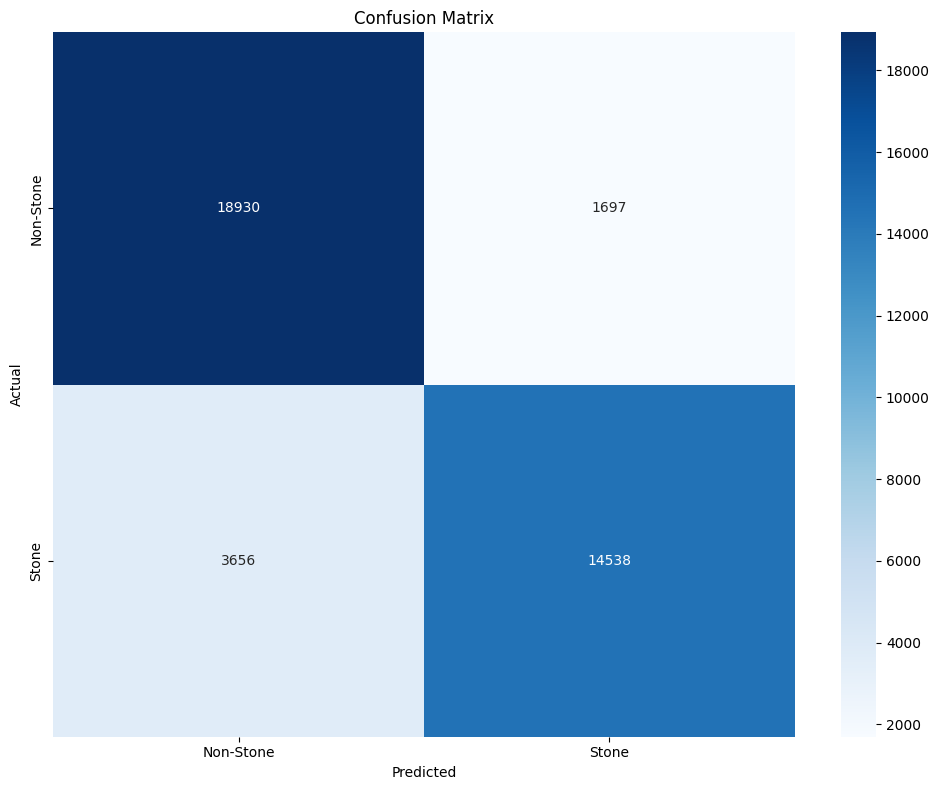

In [7]:
# Plot the confusion matrix
confusion_matrix_fig = evaluator.plot_confusion_matrix()
plt.show()

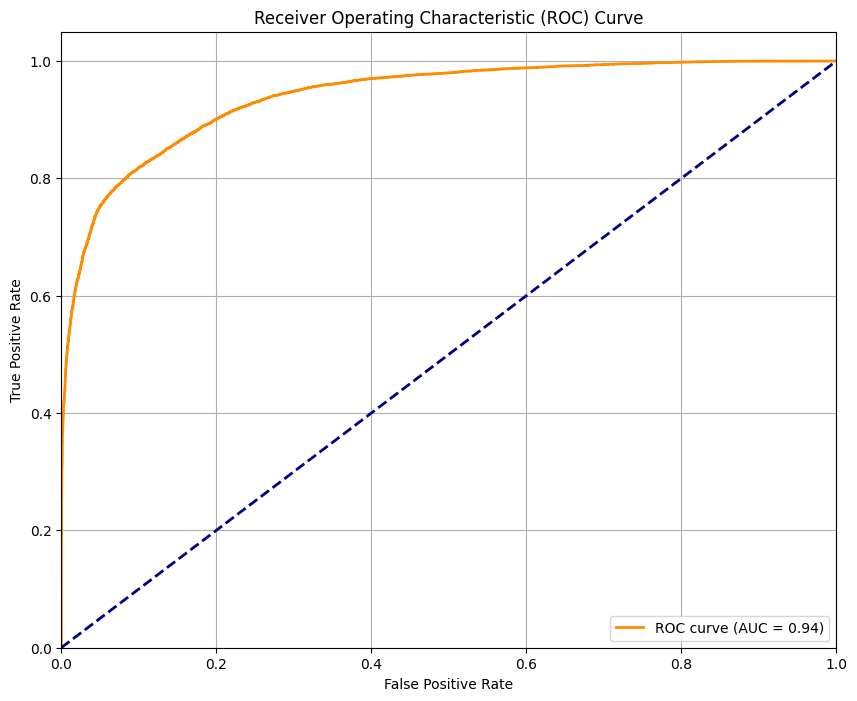

In [8]:
# Plot the ROC curve
roc_curve_fig = evaluator.plot_roc_curve()
plt.show()

1/1 [==============================] - 0s 414ms/step


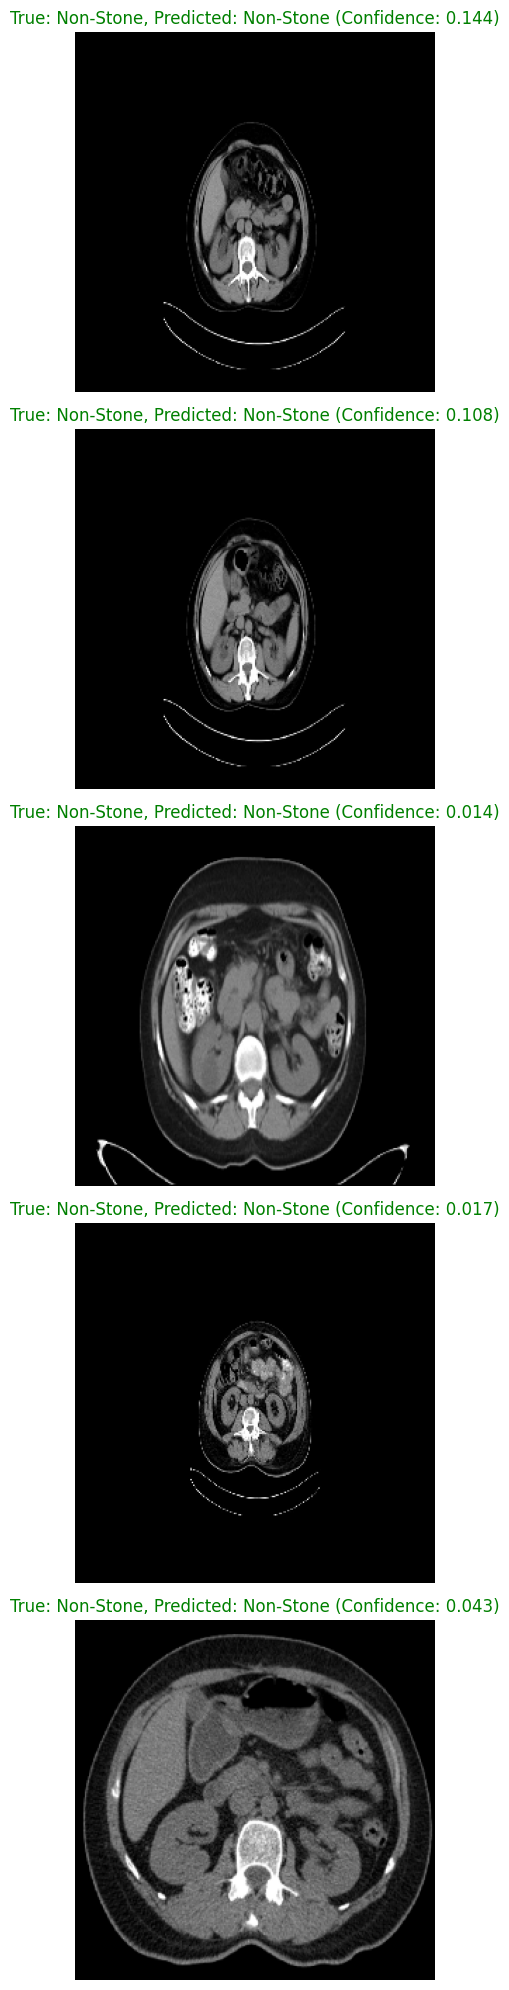

In [9]:
# Plot sample predictions
sample_predictions_fig = evaluator.plot_sample_predictions(num_samples=5)
plt.show()